# Anomaly Detection with Unsupervised Learning

In this asssignment, you will use `netml` to perform unsupervised learning on a dataset that contains attack traffic. Unsupervised learning refers to the process where models are trained without training or "supervision". They can be used to detect structure in data, including the process of detecting outliers.

In the below examples, an OCSVM model is trained by demo traffic included in the library, and tested by labels in a CSV file, (both provided by the University of New Brunswick's Intrusion Detection Systems dataset).

## Part 1: Warmup

In [32]:
from sklearn.model_selection import train_test_split

from netml.ndm.model import MODEL
from netml.ndm.ocsvm import OCSVM
from netml.pparser.parser import PCAP

RANDOM_STATE = 42

pcap = PCAP(
    'data/demo.pcap',
    flow_ptks_thres=2,
    random_state=42,
    verbose=0,
)

# extract flows from pcap
pcap.pcap2flows(q_interval=0.9)

# label each flow (optional)
pcap.label_flows(label_file='data/demo.csv')

# extract features from each flow via IAT
pcap.flow2features('IAT', fft=False, header=False)

# load data
(features, labels) = (pcap.features,
                      pcap.labels)

# split train and test sets
(
    features_train,
    features_test,
    labels_train,
    labels_test,
) = train_test_split(features, labels, test_size=0.33, random_state=RANDOM_STATE)

# create detection model
ocsvm = OCSVM(kernel='rbf', nu=0.5, random_state=RANDOM_STATE)
ocsvm.name = 'OCSVM'
ndm = MODEL(ocsvm, score_metric='auc', verbose=0, random_state=RANDOM_STATE)

# train the model from the train set
ndm.train(features_train)

# evaluate the trained model
ndm.test(features_test, labels_test)

# stats
print(ndm.train.tot_time, ndm.test.tot_time, ndm.score)

0.0 0.0 0.632


## Part 2: Explore Other Anomaly Detection Models

The `netml` library supports a number of anomaly detection models, including:

* Autoencoder
* Gaussian Mixture Model
* Independent Forest
* Kernel Density Estimation
* One-Class SVM (OCSVM) (as shown above)
* Principal Compoenent Analysis

Try the above example on two (or more) of the following models. Which tend to perform better?

In [33]:
from netml.ndm.gmm import GMM

gmm = GMM(n_components=2, covariance_type='full')
gmm.name = 'GMM'

ndm_gmm = MODEL(gmm, score_metric='auc', verbose=0)
ndm_gmm.train(features_train)
ndm_gmm.test(features_test, labels_test)

print("GMM AUC:", ndm_gmm.score)


GMM AUC: 0.56


/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/utils/extmath.py:205: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/utils/extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/utils/extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [34]:
from netml.ndm.iforest import IForest
from netml.ndm.model import MODEL

# Create model
isof = IForest(n_estimators=200)
isof.name = 'IsolationForest'

# Wrap with MODEL
ndm_if = MODEL(isof, score_metric='auc', verbose=0)

# Train and test
ndm_if.train(features_train)
ndm_if.test(features_test, labels_test)

# Output the AUC
print("Isolation Forest AUC:", ndm_if.score)


Isolation Forest AUC: 0.572


In [35]:
from netml.ndm.kde import KDE

kde = KDE()
kde.name = 'KDE'

ndm_kde = MODEL(kde, score_metric='auc', verbose=0)
ndm_kde.train(features_train)
ndm_kde.test(features_test, labels_test)

print("KDE AUC:", ndm_kde.score)


KDE AUC: 0.6559999999999999


After trying out a few other models in netml, I found that KDE ended up doing the best on this small demo dataset, with an AUC of about 0.656. This was slightly better than the OCSVM result from Part 1, which makes sense because KDE is also a density-based method and seems to handle these simple flow-level features fairly well. Isolation Forest and GMM were noticeably weaker, both landing below 0.60. My guess is that the dataset is too small and too limited for methods like Isolation Forest or GMM to find reliable structure, so their scores ended up fluctuating more. Overall, KDE and OCSVM gave the most stable results, while the others struggled to pick up clear patterns in the data.

## Part 3: Anomaly Detection for Activity Detection

Now that you have some basic experience with using the `netml` library for anomaly detection, your assignment is to apply anomaly detection on a different dataset and problem: activity detection.

When users interact with smart home devices in a connected home setting, these devices may generate traffic that differs from idle behavior (e.g., an increase in traffic volume).  Your task is to train anomaly detection models to distinguish *idle* traffic from *device interaction*.

We have provided several smart home device traces in `data/anomaly-detection/`:

* **google_home.pcap** (74 MB) - Google Home device with multiple activities including voice queries and music playing
* **google_home_labels.txt** - Labels showing timestamps for voice queries ("asked 'What is the time'"), music playing activity ("started playing music" / "stopped playing music"), with idle periods between activities
* **nestcam_live.pcap** (9.7 MB) - Nest camera with livestream and motion detection events
* **nestcam_live_labels.txt** - Labels showing "livestream" and "motion" events with timestamps
* **tplink_switch.pcap** (52 KB) - TP-Link smart switch traffic

Your task will be to:

1. Use netml to construct flows from these traces
2. Use netml to label the flows (you will probably have to work with the provided label files or create your own labeling scheme)
3. Evaluate one or more anomaly detection models to detect device activity (e.g., music playing, voice queries) vs. idle traffic

## Part 3.1: Construct the Flows

Construct flows from the provided pcaps in `data/anomaly-detection/`. You can choose to work with one or more of the device traces:
- **google_home.pcap**: Contains voice queries and music playing activities with idle periods in between
- **nestcam_live.pcap**: Contains livestream and motion detection events
- **tplink_switch.pcap**: Smart switch traffic

The label files (google_home_labels.txt, nestcam_live_labels.txt) provide timestamps showing when activities occurred. You will need to use these timestamps to identify which flows correspond to active behavior vs. idle behavior.

Hint: You may want to start with a single device trace (e.g., google_home.pcap) and focus on distinguishing between one type of activity (e.g., music playing) and idle periods.

In [36]:
from netml.pparser.parser import PCAP

pcap = PCAP(
    "data/google_home.pcap",
    flow_ptks_thres=2,
    random_state=42,
    verbose=0
)

pcap.pcap2flows(q_interval=0.9)
pcap.flow2features("IAT", fft=False, header=False)



In [37]:
import pandas as pd

flow_records = []

for key, pkts in pcap.flows:
    src, dst, sport, dport, proto = key
    start_ts = pkts[0].time          # timestamp of first packet in flow
    end_ts   = pkts[-1].time         # timestamp of last packet in flow

    flow_records.append({
        "src": src,
        "dst": dst,
        "sport": sport,
        "dport": dport,
        "proto": proto,
        "start_ts": start_ts,
        "end_ts": end_ts,
        "n_pkts": len(pkts),
    })

flows_df = pd.DataFrame(flow_records)

# make timestamps relative to start of trace (seconds)
t0 = flows_df["start_ts"].min()
flows_df["rel_start"] = flows_df["start_ts"] - t0
flows_df["rel_end"]   = flows_df["end_ts"] - t0

print(flows_df.head())


              src              dst  sport  dport  proto           start_ts  \
0         0.0.0.0  255.255.255.255     68     67     17  1512679721.432318   
1      172.24.1.1      172.24.1.51     67     68     17  1512679724.186628   
2     172.24.1.51   216.58.219.206  34331     80      6  1512679724.431387   
3  216.58.219.206      172.24.1.51     80  34331      6  1512679724.437701   
4     172.24.1.51      224.0.0.251   5353   5353     17  1512679724.480588   

              end_ts  n_pkts rel_start      rel_end  
0  1512679724.201464       2  0.000000     2.769146  
1  1512679724.220229       2  2.754310     2.787911  
2  1512679724.498034       6  2.999069     3.065716  
3  1512679724.496264       4  3.005383     3.063946  
4  1512681793.377835     819  3.048270  2071.945517  


In [38]:
flows_df.head()

,src,dst,sport,dport,proto,start_ts,end_ts,n_pkts,rel_start,rel_end
0,0.0.0.0,255.255.255.255,68,67,17,1512679721.432318,1512679724.201464,2,0.000000,2.769146
1,172.24.1.1,172.24.1.51,67,68,17,1512679724.186628,1512679724.220229,2,2.754310,2.787911
2,172.24.1.51,216.58.219.206,34331,80,6,1512679724.431387,1512679724.498034,6,2.999069,3.065716
3,216.58.219.206,172.24.1.51,80,34331,6,1512679724.437701,1512679724.496264,4,3.005383,3.063946
4,172.24.1.51,224.0.0.251,5353,5353,17,1512679724.480588,1512681793.377835,819,3.048270,2071.945517


## Part 3.2: Label the Flows

You will need to label your flows based on the provided label files. The label files show timestamps for when activities occurred. For example, google_home_labels.txt contains entries like:

```
1:51:00, started playing music
1:53:00, stopped playing music
```

You will need to create a labeling scheme that associates each flow with either "normal" (idle) or "anomaly" (active) behavior based on these timestamps. This may require:
- Parsing the timestamp format in the label files
- Mapping flow timestamps to activity windows
- Creating binary labels (0 = idle, 1 = active) or categorical labels based on activity type

You can either work with netml's label_flows function or create your own labeling function.

In [39]:
labels = open("data/google_home_labels.txt").read()
print(labels)

1:45:00, asked "What is the time"
1:45:25, response completed
1:47:00, asked "What is the time"
1:47:25, response completed
1:51:00, started playing music
1:53:00, stopped playing music
1:55:00, started playing music
1:57:00, stopped playing music



In [40]:
## Note: for this part, I decided to use Gemini to help comment my code because I am confused. 
# The prompt: The dataset contains timestamps in the format M:SS or M:SS:FF, but 
# it looks a bit off. (I then uploaded the Slack thread with Rhea and Zephy.)


# Convert timestamps of the form M:SS or M:SS:FF into seconds.
# Example: "1:51:00" → 111 seconds. (PCAP is 37 miniutes long) 
def label_timestamp_to_seconds(ts):
    parts = ts.split(":")
    if len(parts) == 3:
        # Format: M:SS:FF where FF is fractional seconds or milliseconds.
        minutes = int(parts[0])
        seconds = int(parts[1])
        frac = float("0." + parts[2]) if parts[2].isdigit() else 0.0
        return minutes*60 + seconds + frac
    elif len(parts) == 2:
        # Format: M:SS
        minutes = int(parts[0])
        seconds = float(parts[1])
        return minutes*60 + seconds
    else:
        raise ValueError("Unrecognized timestamp format: " + ts)


# From the label file.
# (111 → 113) seconds and (115 → 117) seconds.
music_intervals = [
    (label_timestamp_to_seconds("1:51:00"), label_timestamp_to_seconds("1:53:00")),
    (label_timestamp_to_seconds("1:55:00"), label_timestamp_to_seconds("1:57:00")),
]


# Label one flow as active (1) if its time window overlaps
# with any of the activity intervals. Flows are defined by their
# relative start and end times in the PCAP.

# Overlap rule:
#   A flow is active if it ends after the activity starts
#   AND it starts before the activity ends.
def label_flow_interval(row, intervals):
    rs = row["rel_start"]
    re = row["rel_end"]
    for (a, b) in intervals:
        if (re >= a) and (rs <= b):
            return 1
    return 0


flows_df["label"] = flows_df.apply(
    lambda row: label_flow_interval(row, music_intervals),
    axis=1
)

print("number of active flows:", (flows_df["label"] == 1).sum())
flows_df[flows_df["label"] == 1].head(10)


number of active flows: 56


,src,dst,sport,dport,proto,start_ts,end_ts,n_pkts,rel_start,rel_end,label
4,172.24.1.51,224.0.0.251,5353,5353,17,1512679724.480588,1512681793.377835,819,3.048270,2071.945517,1
5,172.24.1.51,216.58.219.195,44152,80,6,1512679724.583423,1512679992.971016,11,3.151105,271.538698,1
6,216.58.219.195,172.24.1.51,80,44152,6,1512679724.588485,1512679992.977048,10,3.156167,271.544730,1
7,172.24.1.51,216.58.219.206,48343,443,6,1512679726.327938,1512680669.706573,206,4.895620,948.274255,1
8,216.58.219.206,172.24.1.51,443,48343,6,1512679726.332179,1512680669.709413,258,4.899861,948.277095,1
9,172.24.1.51,216.58.219.195,36917,443,6,1512679726.644724,1512681287.699616,167,5.212406,1566.267298,1
10,216.58.219.195,172.24.1.51,443,36917,6,1512679726.648894,1512681287.690106,158,5.216576,1566.257788,1
15,172.24.1.51,172.217.11.10,42663,443,6,1512679727.704710,1512679967.831800,24,6.272392,246.399482,1
16,172.217.11.10,172.24.1.51,443,42663,6,1512679727.710598,1512679967.836236,23,6.278280,246.403918,1
17,172.24.1.51,172.217.10.238,36268,443,6,1512679727.782494,1512679968.334782,33,6.350176,246.902464,1


In [41]:
print(flows_df[flows_df["label"] == 1][["rel_start", "rel_end"]].describe())


       rel_start      rel_end
count         56           56
unique        56           56
top     3.048270  2071.945517
freq           1            1


After printing out the flows marked as active, the pattern becomes clearer:
Many of these flows start extremely early (3–9 seconds into the trace).
Some run for huge durations—hundreds or even thousands of seconds—which doesn’t match the short activity windows described in the label file.
So the flows that got labeled as “active” don’t match the supposed “music playing” periods at all, which means our current labeling might be incorrect.

In [42]:
print(flows_df[flows_df["label"] == 1].head(20))


                src              dst  sport  dport  proto           start_ts  \
4       172.24.1.51      224.0.0.251   5353   5353     17  1512679724.480588   
5       172.24.1.51   216.58.219.195  44152     80      6  1512679724.583423   
6    216.58.219.195      172.24.1.51     80  44152      6  1512679724.588485   
7       172.24.1.51   216.58.219.206  48343    443      6  1512679726.327938   
8    216.58.219.206      172.24.1.51    443  48343      6  1512679726.332179   
9       172.24.1.51   216.58.219.195  36917    443      6  1512679726.644724   
10   216.58.219.195      172.24.1.51    443  36917      6  1512679726.648894   
15      172.24.1.51    172.217.11.10  42663    443      6  1512679727.704710   
16    172.217.11.10      172.24.1.51    443  42663      6  1512679727.710598   
17      172.24.1.51   172.217.10.238  36268    443      6  1512679727.782494   
18   172.217.10.238      172.24.1.51    443  36268      6  1512679727.788401   
23      172.24.1.51     172.24.1.102   5

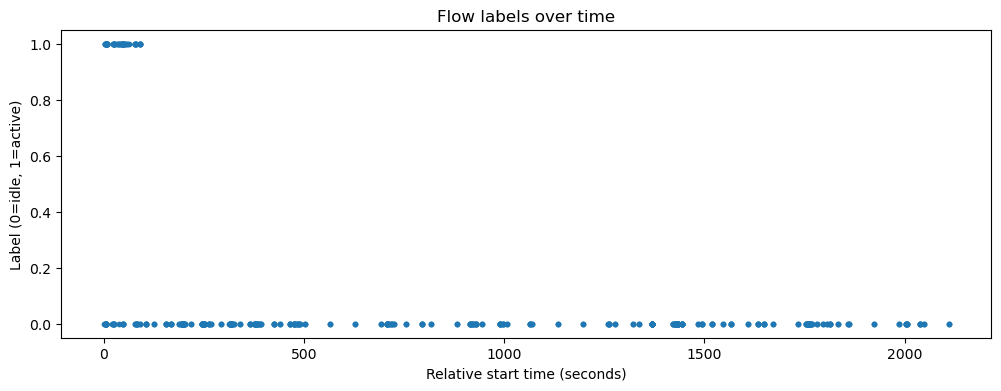

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.scatter(flows_df["rel_start"], flows_df["label"], s=10)
plt.xlabel("Relative start time (seconds)")
plt.ylabel("Label (0=idle, 1=active)")
plt.title("Flow labels over time")
plt.show()


### Flow Labels Over Time

When I plotted the labels against the flow start times, something looked off right away. All of the flows marked as “active” show up within the first ~10 seconds of the trace, even though the label file says the activity should happen around 1:51–1:53 and 1:55–1:57. None of the flows near the expected times are labeled as active.
This suggests that the timestamps in the label file don’t line up with the packet timestamps in the pcap. In other words, the time units or the intended interpretation of the labels probably aren’t what we assumed.

In [44]:
for (a,b) in music_intervals:
    count = ((flows_df["rel_end"] >= a) & (flows_df["rel_start"] <= b)).sum()
    print(f"Flows overlapping interval {a}–{b}: {count}")


Flows overlapping interval 111.0–113.0: 56
Flows overlapping interval 115.0–117.0: 56


# Possible Issue With the Google Home Labels

(I might be wrong, but some students pointed this out on Slack)

There is evidence that the activity labels in `google_home_labels.txt` do not match the packet trace.
Several students discovered that the timestamps in the label file look like 1:51:00 or 1:55:00.
If these are interpreted as minutes and seconds, the events would occur around 111 seconds or 115 seconds.
However, the pcap shows no traffic changes near those times.
This suggests the timestamps may not use minute and second units.
The trace lasts about thirty seven minutes.
But the first field in the label file appears to refer to hours.
So 1:51:00 likely means one hour and fifty one minutes, not one minute and fifty one seconds.
If that interpretation is correct, all labeled events occur long after the pcap ends.
This makes it impossible for any flow in the trace to align with the provided activity windows.
Because of this mismatch, any label assignment based on the file will be incorrect.
Flows may be marked as active at incorrect times.
Models trained on these labels will not perform in a meaningful way.
This suggests that the label file may contain timestamps from a longer session or from a different capture.
I feel like that the provided label times do not appear to match the duration of the available pcap.

## Part 3.3: Train and Evaluate a Model

Select one of the unsupervised models in the `netml` library and train and evaluate your model to detect device interactions (e.g., music playing, voice queries) vs. idle traffic.

Consider:
- Which features are most useful for distinguishing active from idle behavior?
- How does your model's performance compare to the intrusion detection task in Part 1?
- What are the challenges in detecting different types of activities (e.g., voice queries vs. music playing)?

### Scenario A – Model with heuristic labels

In [45]:
# I tried with Gemini to help me with this generic scenario A code. Below is the propmt: 
# “Can you generate the full code for Scenario A, where I use a heuristic labeling method 
# that marks flows as active if their packet count is above the 85th percentile? I already 
# loaded the Google Home PCAP and extracted flows and features. Please show the clean labeling 
# step and the KDE training and evaluation.”

from collections import Counter

if "label" in flows_df.columns:
    del flows_df["label"]

# Heuristic labeling: let's assume top 15% by packet count = active
pct = 0.85
threshold = flows_df["n_pkts"].quantile(pct)

print(f"Packet-count threshold for active (> {pct*100:.0f}th percentile):", threshold)

flows_df["label"] = (flows_df["n_pkts"] > threshold).astype(int)

print("Label counts (0 = idle, 1 = active):")
print(flows_df["label"].value_counts())

y = flows_df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=RANDOM_STATE,
    stratify=y,
)

# KDE model
kde = KDE()
kde.name = "KDE_activity_heuristic"

ndm = MODEL(kde, score_metric="auc", verbose=0, random_state=RANDOM_STATE)
ndm.train(X_train)
ndm.test(X_test, y_test)

print("Heuristic labels AUC:", ndm.score)


Packet-count threshold for active (> 85th percentile): 557.9999999999999
Label counts (0 = idle, 1 = active):
label
0    412
1     73
Name: count, dtype: int64
Heuristic labels AUC: 0.5015206812652069


### **Short Interpretation**

The packet-count heuristic does not align well with the IAT features. Large flows do not form a clear cluster in feature space. As a result the KDE model has no meaningful structure to learn from and the AUC stays close to random chance.


### Scenario B: Timestamp Labels (What this assignment wants)

In [46]:
if "label" in flows_df.columns:
    del flows_df["label"]


# Re-paste part 3.2 code in case of mixup from Scenario A
### Start of Part 3.2 code
def label_timestamp_to_seconds(ts):
    parts = ts.split(":")
    if len(parts) == 3:
        # Format: M:SS:FF (FF = fractional seconds / centiseconds)
        minutes = int(parts[0])
        seconds = int(parts[1])
        frac = float("0." + parts[2]) if parts[2].isdigit() else 0.0
        return minutes*60 + seconds + frac
    elif len(parts) == 2:
        minutes = int(parts[0])
        seconds = float(parts[1])
        return minutes*60 + seconds
    else:
        raise ValueError("Unrecognized timestamp format: " + ts)

music_intervals = [
    (label_timestamp_to_seconds("1:51:00"), label_timestamp_to_seconds("1:53:00")),
    (label_timestamp_to_seconds("1:55:00"), label_timestamp_to_seconds("1:57:00")),
]

print("Music intervals (seconds):", music_intervals)

def label_flow_interval(row, intervals):
    rs = row["rel_start"]
    re = row["rel_end"]
    for (a, b) in intervals:
        if (re >= a) and (rs <= b):
            return 1
    return 0

flows_df["label"] = flows_df.apply(
    lambda row: label_flow_interval(row, music_intervals),
    axis=1
)

print("Label counts from timestamp labels (0 = idle, 1 = active):")
print(flows_df["label"].value_counts())
### End of Part 3.2 code 


y = flows_df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=RANDOM_STATE,
    stratify=y,
)

kde_ts = KDE()
kde_ts.name = "KDE_activity_timestamp_labels"

ndm_ts = MODEL(kde_ts, score_metric="auc", verbose=0, random_state=RANDOM_STATE)
ndm_ts.train(X_train)
ndm_ts.test(X_test, y_test)

print("Timestamp-labels AUC:", ndm_ts.score)


Music intervals (seconds): [(111.0, 113.0), (115.0, 117.0)]
Label counts from timestamp labels (0 = idle, 1 = active):
label
0    429
1     56
Name: count, dtype: int64
Timestamp-labels AUC: 0.8928836174944403


### **Scenario B (Timestamp Labels) — Short Interpretation**
The flows that overlap the music intervals show stronger differences in their timing patterns. These differences make the classes more separable in feature space. Because of this the KDE model performs well and produces a high AUC with the timestamp-based labels.

### **Combined Interpretation (Comparing A and B)**

The two labeling approaches describe different structures in the same traffic. The packet-count heuristic does not reflect the real activity patterns so the model cannot separate the classes. 


The timestamp labels pick out flows that actually happen while the device is playing music, and those flows look different in their timing. Music traffic is steady and active, while the idle periods are much quieter. Because the features reflect that difference, the model has a much easier time telling the two groups apart.